In [81]:
import sys, os 
import numpy as np
import math

import matplotlib.pyplot as plt
from itertools import product
import importlib

if importlib.util.find_spec('matplotlib'):
    import matplotlib
    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties
    matplotlib.font_manager._rebuild()

if importlib.util.find_spec('ipywidgets'):
    from ipywidgets.widgets import IntSlider
    from ipywidgets import interact

In [95]:
# credit to Alper Kamil
def states(gridmap):
    """State generator.

    Yields
    ------
    state: tuple
        State coordinates (i,j).
    """
    n_rows, n_cols = gridmap.shape
    for state in product(range(n_rows),range(n_cols)):
        yield state
        
def plot(gridmap, figsize = 8, diff_agent=False,value=None, policy=None, agent=[0,0], dispval=False, save=None, hidden=[], path={}):
        """Plots the values of the states as a color matrix.
        
        Parameters
        ----------
        value : array, shape=(n_mdps,n_qs,n_rows,n_cols) 
            The value function. If it is None, the reward function will be plotted.
            
        policy : array, shape=(n_mdps,n_qs,n_rows,n_cols) 
            The policy to be visualized. It is optional.
            
        agent : tuple
            The position of the agent to be plotted. It is optional.
        
        save : str
            The name of the file the image will be saved to. It is optional
        """
        
        f=FontProperties(weight='bold')
        fontname = 'Times New Roman'
        fontsize = 20
        
        # Up, Down, Right, Left
        A = ['U','D','R','L']  
        
        # Dimensions
        n_rows, n_cols = gridmap.shape

        if value is not None:
            value = np.copy(value)
            for h in hidden:
                value[h] = 0
        
        cmap =plt.cm.RdBu
        # Plot
        fig = plt.figure(figsize=(figsize,figsize))
        plt.rc('text', usetex=True)
        threshold = np.nanmax(np.abs(value))*2 if value is not None else 0
        threshold = 1 if threshold==0 else threshold 
        
        if value is None:
            temp = np.zeros(gridmap.shape)
            plt.imshow(temp, interpolation='nearest', cmap=cmap, vmax=threshold, vmin=-threshold)
        else:
            plt.imshow(value, interpolation='nearest', cmap=cmap, vmax=threshold, vmin=-threshold)  
        
        structure = gridmap if gridmap is not None else np.full(gridmap.shape,'E')
        
        # Get the axes
        ax = fig.axes[0]

        # Major ticks
        ax.set_xticks(np.arange(0, n_cols, 1))
        ax.set_yticks(np.arange(0, n_rows, 1))

        # # Labels for major ticks
        # ax.set_xticklabels(np.arange(n_cols+1), fontsize=fontsize)
        # ax.set_yticklabels(np.arange(n_rows+1), fontsize=fontsize)

        # Minor ticks
        ax.set_xticks(np.arange(-.5, n_cols, 1), minor=True)
        ax.set_yticks(np.arange(-.5, n_rows, 1), minor=True)
        
        # Move x axis to the top
        ax.xaxis.tick_top()
    
        # Gridlines based on minor ticks
        ax.grid(which='minor', color='lightgray', linestyle='-', linewidth=1,alpha=0.5)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        ax.tick_params(bottom='off', left='off')
        
        # Draw the agent
        if agent: 
            if diff_agent:
                # print('diff true')
                circle=plt.Circle((agent[1],agent[0]-0.17),0.26,color='lightgreen',ec='orange',lw=4)
                plt.gcf().gca().add_artist(circle)
            else:
                circle=plt.Circle((agent[1],agent[0]-0.17),0.26,color='lightblue',ec='purple',lw=2)
                plt.gcf().gca().add_artist(circle)

        for i, j in states(gridmap):  # For all states
            if (i,j) in path:
                if 'u' in path[i,j]:
                    rect=plt.Rectangle((j-0.4,i+0.4),+0.8,-0.9,color='lightcoral')
                    plt.gcf().gca().add_artist(rect)
                if 'd' in path[i,j]:
                    rect=plt.Rectangle((j-0.4,i-0.4),+0.8,+0.9,color='lightcoral')
                    plt.gcf().gca().add_artist(rect)
                if 'r' in path[i,j]:
                    rect=plt.Rectangle((j-0.4,i-0.4),+0.9,+0.8,color='lightcoral')
                    plt.gcf().gca().add_artist(rect)
                if 'l' in path[i,j]:
                    rect=plt.Rectangle((j+0.4,i-0.4),-0.9,+0.8,color='lightcoral')
                    plt.gcf().gca().add_artist(rect)
                    
            cell_type = gridmap[i,j]
            # If there is an obstacle
            if cell_type == 'B':
                circle=plt.Circle((j,i),0.49,color='k',alpha=0.5,fc='darkgray')
                plt.gcf().gca().add_artist(circle)
                continue
            # If it is a trap cell
            elif cell_type == 'T':
                circle=plt.Circle((j,i),0.49,color='k',fill=False)
                plt.gcf().gca().add_artist(circle)
                
            # If it is a directional cell (See the description of the class attribute 'structure' for details)
            elif cell_type == 'U':
                triangle = plt.Polygon([[j,i],[j-0.5,i+0.5],[j+0.5,i+0.5]], color='gray')
                plt.gca().add_patch(triangle)
            elif cell_type == 'D':
                triangle = plt.Polygon([[j,i],[j-0.5,i-0.5],[j+0.5,i-0.5]], color='gray')
                plt.gca().add_patch(triangle)
            elif cell_type == 'R':
                triangle = plt.Polygon([[j,i],[j-0.5,i+0.5],[j-0.5,i-0.5]], color='gray')
                plt.gca().add_patch(triangle)
            elif cell_type == 'L':
                triangle = plt.Polygon([[j,i],[j+0.5,i+0.5],[j+0.5,i-0.5]], color='gray')
                plt.gca().add_patch(triangle)
            
            # If the background is too dark, make the text white
            if value is not None:
                color = 'white' if np.abs(value[i, j]) > threshold/2 else 'black'
            else:        
                color = 'white' if np.abs(temp[i, j]) > threshold/2 else 'black'
            
            if (policy is None and value is not None) or dispval:  # Print the values       
                v = str(value[i,j]).zfill(3)
                plt.text(j, i, '$'+v+'$',horizontalalignment='center',color=color,fontname=fontname,fontsize=fontsize+2)  # Value
                
            # Draw the arrows to visualize the policy
            elif (value is None or value[i,j] > 0) and policy is not None:  
                if len(policy[i,j]) >= len(A):
                    plt.text(j, i-0.05,r'$\epsilon_'+str(policy[i,j]-len(A))+'$', horizontalalignment='center',color=color,fontsize=fontsize+5)
                elif not policy[i,j] == 'o':
                    action_name = policy[i,j]
                    #print(action_name)
                    if action_name == 'n':
                        plt.arrow(j,i,0,-0.2,head_width=.2,head_length=.15,color=color)
                    elif action_name == 's':
                        plt.arrow(j,i-.3,0,0.2,head_width=.2,head_length=.15,color=color)
                    elif action_name == 'e':
                        plt.arrow(j-.15,i-0.15,0.2,0,head_width=.2,head_length=.15,color=color)
                    elif action_name == 'w':
                        plt.arrow(j+.15,i-0.15,-0.2,0,head_width=.2,head_length=.15,color=color)
            
            # Plot the labels
            # surplus = 0.2 if (i,j) in hidden else 0
            # if self.label[i,j] in self.lcmap:
            #     circle=plt.Circle((j, i+0.24-surplus),0.2+surplus/2,color=self.lcmap[self.label[i,j]])
            #     plt.gcf().gca().add_artist(circle)
            # if self.label[i,j]:
            #     plt.text(j, i+0.4-surplus,'$'+','.join(self.label[i,j])+'$',horizontalalignment='center',color=color,fontproperties=f,fontname=fontname,fontsize=fontsize+5+surplus*10)
            
        if save:
            plt.savefig(save,bbox_inches='tight')
            
def plot_list(gridmap, value_list,policy_list=None):
        """Plots the list of state values with a slider.
        
        Parameters
        ----------
        value_list : list of arrays with shape=(n_mdps,n_qs,n_rows,n_cols) 
            The list value functions.
            
        policy_list : list of arrays with  shape=(n_mdps,n_qs,n_rows,n_cols) 
            The policy to be visualized. It is optional.
        """
        # A helper function for the slider
        def plot_value(t):
            if policy_list is not None:
                plot(gridmap, value=value_list[t], policy=policy_list[t], dispval=True)
            else:
                plot(gridmap, value=value_list[t], dispval=True)
            
        T = value_list.shape[0]
        w=IntSlider(value=0,min=0,max=T-1)
        
        interact(plot_value,t=w)

In [50]:
# Using readlines()

file1 = open('cvar_out_25.out', 'r')
Lines = file1.readlines()
Lines

['States\n',
 '25\n',
 'Policy\n',
 '[east, south, obstacle, east, south, east, east, east, north, south, obstacle, south, north, obstacle, south, east, east, east, east, south, obstacle, north, obstacle, east, null]\n',
 'Alpha values\n',
 '[0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]\n',
 'Max number of actions\n',
 '4\n',
 '36.472,36.472,37.472,37.472,31.497,35.472,36.572,0.000,30.000,0.000,0.000,0.000,11.112,14.353,31.010,0.000,8.293,7.323,9.404,0.000,35.472,31.497,36.572,37.372,34.524,36.041,36.472,0.000,17.527,35.476,31.497,0.000,31.000,31.000,13.503,0.000,6.908,6.003,11.112,0.000,30.000,0.000,0.000,0.000,35.491,35.228,35.472,0.000,32.000,32.000,34.524,0.000,30.000,0.000,0.000,0.000,5.381,4.422,31.000,0.000,34.956,33.217,35.761,34.174,34.174,35.761,36.203,0.000,31.000,31.000,35.491,0.000,4.111,4.111,32.000,0.000,4.000,3.111,5.391,0.000,30.000,0.000,0.000,0.000,34.174,35.761,34.956,0.000,30.000,0.000,0.000,0.000,3.111,4.000,31.000,0.000,0.000,0.000,0.000,0.000,\n',
 '32.894,32.894,33.894

In [51]:
rows=cols = int(math.sqrt(float(Lines[1][:-1])))
list_policy = Lines[3].strip('[]').replace(' ', '').split(',')

In [52]:
alpha_val = Lines[5].strip('[]').replace(' ', '').split(',')
alpha_val[-1] = alpha_val[-1][:-2]
alpha_val = [float(e) for e in alpha_val]
alpha_val

[0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]

In [53]:
nactions = int(float(Lines[7][:-1]))
nactions

4

In [58]:
action_val = np.zeros([len(alpha_val),rows,cols,nactions])
min_val = np.zeros([len(alpha_val),rows, cols])

start_line = 8
for a in range(len(alpha_val)):
    temp = Lines[start_line+a].strip('[]').replace(' ', '').split(',')
    index = 0
    for i in range(rows):
        for j in range(cols):
            action_val[a][i][j] = [float(e) if float(e) !=0 else np.nan for e in temp[index:index+nactions]]
            min_val[a][i][j] = np.nanmin(action_val[a][i][j])

            index += nactions

action_val[6][0][0]

16 8
16 9
16 10
16 11
16 12
16 13
16 14
13.286


/root/.venvs/csrl/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: All-NaN slice encountered
  if sys.path[0] == '':


array([13.286, 13.286, 14.286, 14.286])

30.0


interactive(children=(IntSlider(value=0, description='t', max=6), Output()), _dom_classes=('widget-interact',)…

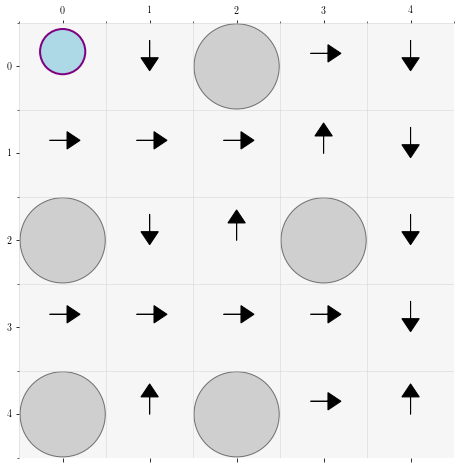

In [96]:
gridmap = np.zeros([rows,cols], dtype=str) 
policy= np.zeros([rows,cols], dtype=str) 
index = 0
for i in range(rows):
    for j in range(cols):
        gridmap[i][j] = 'B' if list_policy[index] == 'obstacle' else 'E'
        policy[i][j] = list_policy[index]
        index +=1

print(min_val[6][0][2])        
plot_list(gridmap, min_val)
plot(gridmap, figsize=8, policy =policy)

### Plotting Traditional VI 

In [76]:
file2= open('strat_25.dot', 'r')
Lines2 = file2.readlines()

rows2=cols2 = int(math.sqrt(float(Lines2[1][:-1])))
list_policy2 = Lines2[3].strip('[]').replace(' ', '').split(',')

gridmap2 = np.zeros([rows,cols], dtype=str) 
policy2= np.zeros([rows,cols], dtype=str) 
index2 = 0
for i in range(rows):
    for j in range(cols):
        gridmap2[i][j] = 'B' if list_policy[index2] == 'obstacle' else 'E'
        policy2[i][j] = list_policy[index2]
        index2 +=1

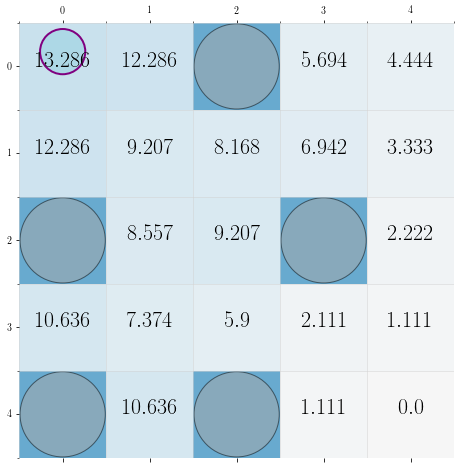

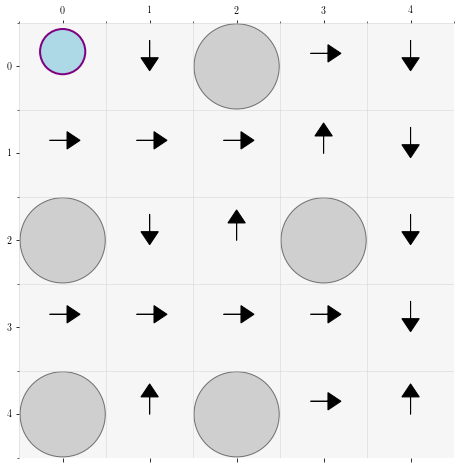

In [80]:
min_val2 = np.zeros([rows, cols])

start_line = 6
temp_list= Lines2[start_line].strip('[]').replace(' ', '').split(',')
index = 0

for i in range(rows):
        min_val2[i] = [float(e) for e in temp_list[index:index+cols]]
        index += cols

min_val2[0]
plot(gridmap2, figsize=8, policy =policy2, value=min_val2, dispval=True)      
plot(gridmap2, figsize=8, policy =policy2)